# Pokemon generation with GANs
- Vanilla GAN with Keras
- Convert RGBA to RGB (PNG to JPG)
## Dataset
- Pokemon Image Dataset, https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

## 1) Import Packages

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio

import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

## 2) Make Dataset

In [25]:
def load_and_preprocessing(dir):
    data = []
    img_list = os.listdir(dir)
    for name in img_list :
        
        png = imageio.imread(dir + name)
        png = Image.fromarray(png)
        png.load()  # for splitting
        
        # convert RGBA to RGB -> alpha channel
        if(len(png.split()) == 4):
            img = Image.new('RGB', png.size, (255, 255, 255)) # white
            img.paste(png, mask = png.split()[3])
        else:
            img = png
            
        images = tf.keras.preprocessing.image.img_to_array(img)
        images /= 255.  # preprocessing
        
        data.append(images)
        
    return np.stack(data)

In [26]:
dir = "images/"
img_list = os.listdir(dir)
img_len = len(os.listdir(dir))

print("The number of images :",img_len)
print(img_list[0:10])

The number of images : 809
['abomasnow.png', 'abra.png', 'absol.png', 'accelgor.png', 'aegislash-blade.png', 'aerodactyl.png', 'aggron.png', 'aipom.png', 'alakazam.png', 'alomomola.png']


In [29]:
# Make dataset
dataset = load_and_preprocessing(dir)
print("Shape of dataset :", dataset.shape)

Shape of dataset : (809, 120, 120, 3)


## 3) Explore Dataset

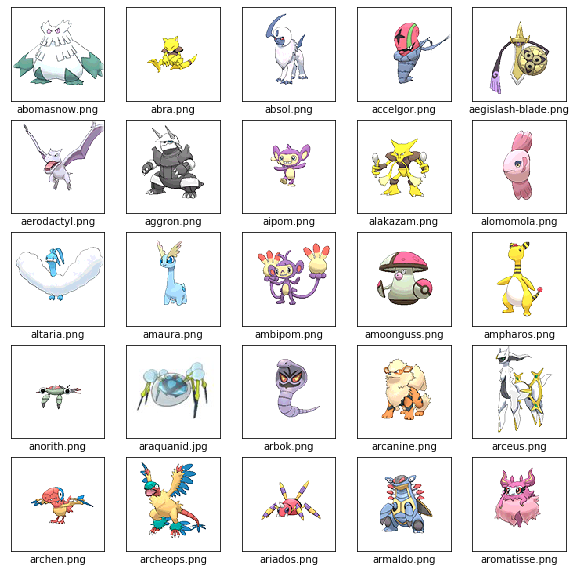

In [30]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = np.reshape(dataset[i,:] , [120,120,3])
    plt.imshow(image)
    plt.xlabel(img_list[i])
plt.show()

## 4) Generator

In [38]:
# params
latent_dim = 100
height = 120
width = 120
channels = 3

In [62]:
generator_input = layers.Input(shape=(latent_dim,))
g = layers.Dense(128 * 15 * 15)(generator_input)
g = layers.Reshape((15, 15, 128))(g)

g = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(g)
g = layers.BatchNormalization(momentum=0.8)(g)
g = layers.ReLU()(g)

g = layers.Conv2D(channels, 3, activation='tanh', padding='same')(g)

generator = Model(generator_input, g)
generator.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 28800)             2908800   
_________________________________________________________________
reshape_12 (Reshape)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_39 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
re_lu_21 (ReLU)              (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 60, 60, 128)       147

## 5) Discriminator

In [73]:
discriminator_input = layers.Input(shape=(height, width, channels))

d = layers.Conv2D(128, 3, strides=2, padding='same')(discriminator_input)
d = layers.LeakyReLU(alpha=0.2)(d)

d = layers.Conv2D(128, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU(alpha=0.2)(d)

d = layers.Conv2D(64, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU()(d)

d = layers.Conv2D(64, 3, strides=2, padding='same')(d)
d = layers.BatchNormalization(momentum=0.8)(d)
d = layers.LeakyReLU()(d)

d = layers.Flatten()(d)
d = layers.Dense(1, activation='sigmoid')(d)

discriminator = Model(discriminator_input, d)
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 60, 60, 128)       3584      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_48 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 15, 15, 64)        737

## 6) GANs - Training

In [78]:
gan_input = layers.Input(shape=(latent_dim,))
discriminator.trainable = False

gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [81]:
batch_size = 128

def train(epochs, print_step):
    hist = []
    
    for epoch in range(epochs):
        
        real_images = dataset[np.random.randint(0, dataset.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator
        dis_loss_real = discriminator.train_on_batch(real_images, real_label)
        dis_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        dis_loss = 0.5 * np.add(dis_loss_real, dis_loss_fake)
        
        # Generator
        gene_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        record = (epoch, dis_loss[0], gene_loss[0])
        hist.append(record)

        if epoch % print_step == 0:
            print("%5d iteration - discriminator loss: %.3f, generator loss: %.3f" % record)
            
    return hist

In [84]:
import warnings
warnings.simplefilter("ignore")

In [93]:
%%time
hist_1000 = train(750, 10)

    0 iteration - discriminator loss: 0.786, generator loss: 1.151
   10 iteration - discriminator loss: 0.761, generator loss: 1.071
   20 iteration - discriminator loss: 0.651, generator loss: 1.293
   30 iteration - discriminator loss: 0.520, generator loss: 1.431
   40 iteration - discriminator loss: 0.533, generator loss: 1.776
   50 iteration - discriminator loss: 0.370, generator loss: 1.958
   60 iteration - discriminator loss: 0.662, generator loss: 2.860
   70 iteration - discriminator loss: 1.404, generator loss: 2.177
   80 iteration - discriminator loss: 0.550, generator loss: 3.708
   90 iteration - discriminator loss: 0.512, generator loss: 2.041
  100 iteration - discriminator loss: 0.467, generator loss: 1.941
  110 iteration - discriminator loss: 0.555, generator loss: 1.649
  120 iteration - discriminator loss: 0.611, generator loss: 1.478
  130 iteration - discriminator loss: 0.668, generator loss: 1.273
  140 iteration - discriminator loss: 0.702, generator loss: 1

## 7) Save Models

In [94]:
generator.save_weights('gan_g_weights_750.h5')
discriminator.save_weights('gan_d_weights_750.h5')

## 8) Visualization of generated images

In [150]:
def visualization(generated_images, n=4, m=8):
    fig = plt.figure(figsize = (10,10))
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()

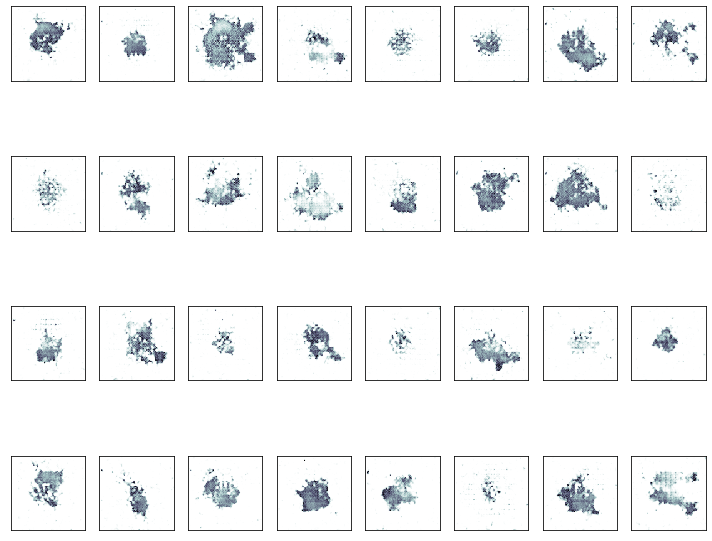

In [152]:
noise_data = np.random.normal(0, 1, size=(32, latent_dim))
visualization(0.5 * generator.predict(noise_data) + 0.5)

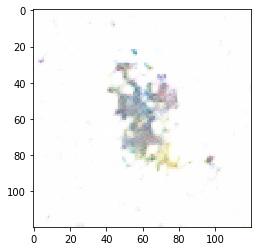

In [169]:
noise_data = np.random.normal(0, 1, size=(1, latent_dim))
pr = generator.predict(noise_data)
pr = np.reshape(pr, (120, 120, 3))
plt.imshow(0.5*pr + 0.5)
plt.show()